<a href="https://colab.research.google.com/github/soulayman-al-abdallah/TimeSeries-OilPrice-Analysis/blob/main/1__ARIMA_Oil_price_TS_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Oil Price Time series data analysis and modeling.

Data downloaded from [here](https://github.com/soulayman-al-abdallah/public-repo.git)

Steps applied:
- Data Cleaning
- Data Visualizing
- Data Decomposition
- Stationarity Check
- Making the data stationary
- ARIMA Model tuning, fitting, forecasting and evaluating




---



# Importing and Cleaning data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn import preprocessing

import statsmodels.tsa.api as smt    #statsmodel : imp pandas package #tsa : time series analysis

from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import autocorrelation_plot

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 16, 8

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats import chisquare
import itertools
import warnings 
warnings.filterwarnings('ignore')

In [ ]:
!pip install pmdarima

In [ ]:
!git clone https://github.com/soulayman-al-abdallah/public-repo.git

Cloning into 'public-repo'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 12 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (12/12), 5.82 MiB | 4.05 MiB/s, done.


In [ ]:
df = pd.read_csv('/content/public-repo/BrentOilPrice.csv').drop(['Unnamed: 0'],axis=1)
df

,Date,Price
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63
...,...,...
7636,2017-06-20,43.98
7637,2017-06-21,44.62
7638,2017-06-22,44.46
7639,2017-06-23,44.14


In [ ]:
# Converting Date column to a datetime data type
df["Date"] = pd.to_datetime(df['Date']) 
df.head(3)

,Date,Price
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55


In [ ]:
df.tail(3)

,Date,Price,Year,Month
7638,2017-06-22,44.46,2017,6
7639,2017-06-23,44.14,2017,6
7640,2017-06-26,44.09,2017,6


In [ ]:
# Get the shape of the dataset
print(df.shape)
# Statistical characteristics of the dataset
print(df.describe())

(7641, 2)
             Price
count  7641.000000
mean     44.875166
std      33.383360
min       9.100000
25%      18.500000
50%      28.460000
75%      64.700000
max     143.950000


In [ ]:
# To check if the data contains any null value
print(df.isnull().sum()) 

Date     0
Price    0
dtype: int64




---



#Visualizing data

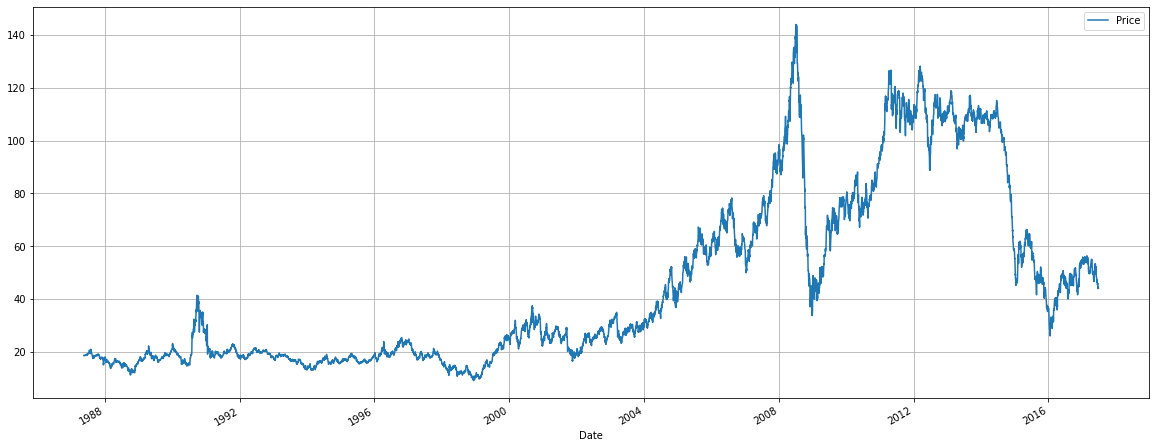

In [ ]:
df.plot(x='Date' , y='Price', figsize=(20,8), grid=True)

In [ ]:
# Creating a column with month and year values extracted from the date column that was converted to datetime data type

df["Year"] = pd.to_datetime(df["Date"]).dt.year 
df["Month"] = pd.to_datetime(df["Date"]).dt.month
df.head(3)

,Date,Price,Year,Month
0,1987-05-20,18.63,1987,5
1,1987-05-21,18.45,1987,5
2,1987-05-22,18.55,1987,5


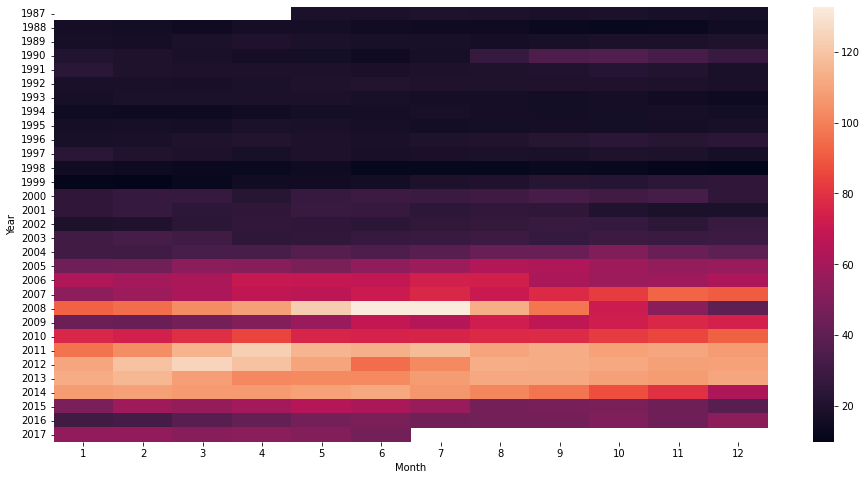

In [ ]:
# Plotting the heat map
plot = df.pivot_table('Price', 'Year', 'Month')
heatMap = sns.heatmap(plot)



---



#Analysis

##**Data Decomposition**

In [ ]:
df = df.set_index(['Date'])

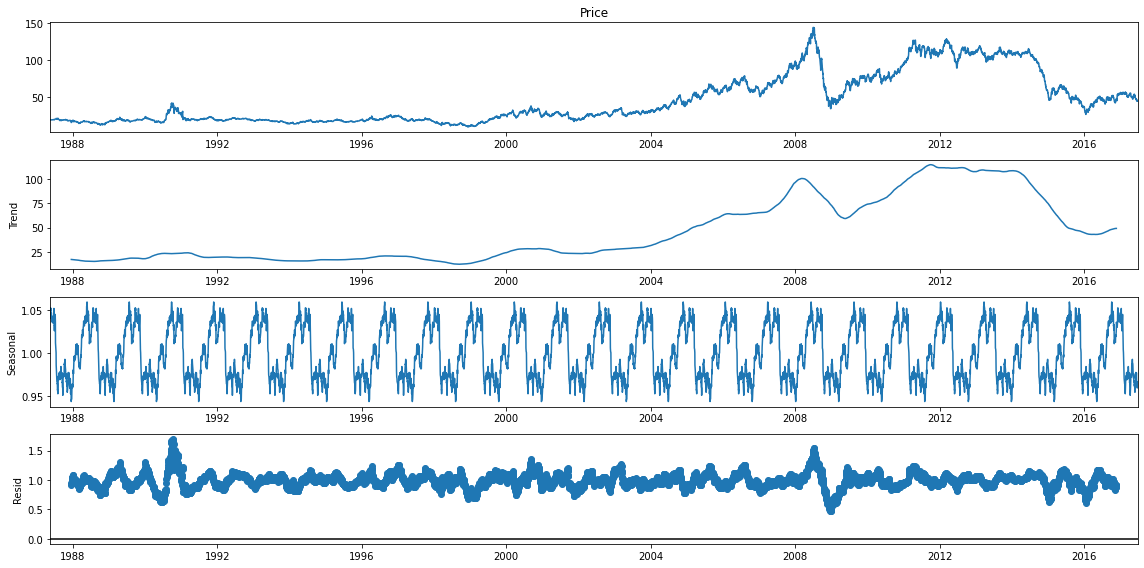

In [ ]:
# Let's try decomposing the series to see individual components of the series.
from statsmodels.tsa.seasonal import seasonal_decompose
result_dec = seasonal_decompose(df['Price'],freq=300, model = 'multiplicative')
fig_plot = result_dec.plot()


##**Checking Stationarity**

**Stationarity check** through:
- Visual Interpretation of rolling mean and rolling std
- Summary statistics
- Standard statistics (ADF and KPss)


In this approach we plot the data and judge whether the data is stationary or not based on intuition developed via pictorial representations.

###**Visual Interpretation**

we plot the data and judge whether the data is stationary or not based on intuition developed via pictorial representations.

In [ ]:
from statsmodels.tsa.stattools import adfuller

def stationarity_test(timeseries):
    """
    Pass in a time series, returns ADF report
    """
    #Determing rolling statistics
    rollingMean = timeseries.rolling(window = 200).mean()
    rollingStd = timeseries.rolling(window = 200).std()
    
    #Plot rolling statistics:
    original = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rollingMean, color='red', label='Rolling Mean')
    std = plt.plot(rollingStd, color='black', label = 'Rolling Std')
    plt.xlabel('Date')
    plt.ylabel('Oil Prices')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

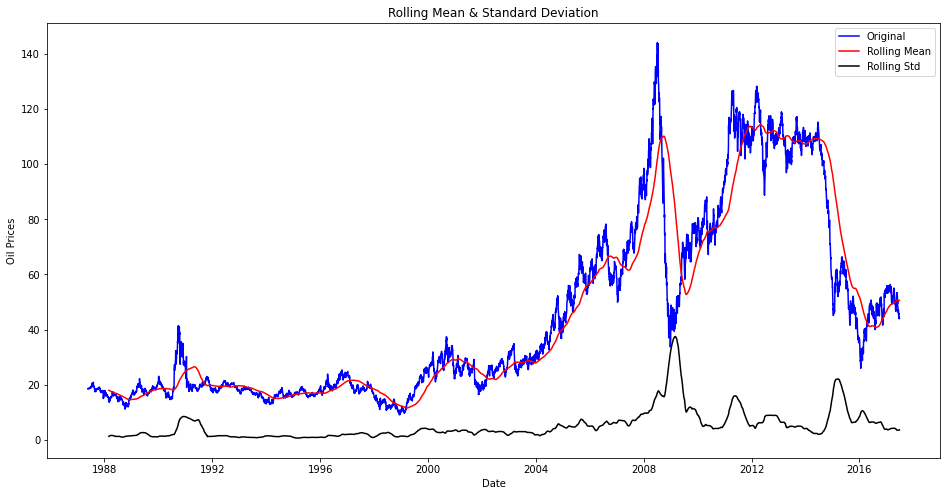

In [ ]:
stationarity_test(df['Price'])

The mean and std are not constant over time so prices data is not stationary.

Based on the above plots, it is evident that there is a particular trend in our data. Also the data is not completely normal.
However, this is a purely qualitative approach. Next let us explore a bit more quantitative check of stationarity.



---



###**Summary statistics**

In this method, we calculate the summary statistics, such as mean, over different segments of the data. If the statistics are changing drastically, then it means that the data is non-stationary.

In [ ]:
# Grouping yearly and calculating its mean 
means_over_dataset = df.groupby(by = df.index.year).mean()
means_over_dataset['Price']

Date
1987     18.525813
1988     14.905412
1989     18.228228
1990     23.761445
1991     20.041128
1992     19.319728
1993     17.013413
1994     15.856389
1995     17.015850
1996     20.639803
1997     19.108508
1998     12.758103
1999     17.901566
2000     28.660672
2001     24.455720
2002     24.993255
2003     28.850814
2004     38.259693
2005     54.574553
2006     65.161765
2007     72.441160
2008     96.944348
2009     61.738770
2010     79.609444
2011    111.264274
2012    111.570683
2013    108.555000
2014     98.969606
2015     52.316549
2016     43.674141
2017     51.732177
Name: Price, dtype: float64

From this test, it is evident that the mean varies considerably with time. However, this is still a subjective notion. i.e. different individuals may have different notions as to what classifies as a significant change.
Therefor, we need a more full proof test.



---



###**Standard Statistical tests**

There are 2 tests that can be utilized to judge the stationarity of a dataset.



*   Augmented Dickey-Fuller Test (ADF Test)
*   Kwiatkowski-Phillips-Schmidt-Shin Test (KPSS Test)




**ADF Test**

- Null Hypothesis: H0 =  The series has a unit root (value of a =1). i.e. **Data is Non-Stationary**


- Alternate Hypothesis: H1 =  The series does not have a unit root. i.e. **Data is Stationary**

If the ADF value is less than the critical values, we reject H0 and vice versa.
Or if the p value is less than the critical tolerance levels, 10%, 5% and 1%, then we reject H0 and vice versa.

In [ ]:
adf_test = adfuller(df['Price'])
print("ADF Value- ", adf_test[0])
print("p Value - ", adf_test[1])
print("No. of Lags used - ", adf_test[2])
print("No. of Observations used - ", adf_test[3])
print("Critical Values - ", adf_test[4])

ADF Value-  -1.8674550706481725
p Value -  0.3475226862363653
No. of Lags used -  35
No. of Observations used -  7605
Critical Values -  {'1%': -3.431210158922485, '5%': -2.861920125894976, '10%': -2.5669723365367867}


Since the ADF value is greater than the critical values, we cannot reject H0. Also, the p value is greater than all critical levels. This is proof that H0 cannot be rejected and hence the **data is non-stationary** by **ADF test**.



---



**KPSS Test**

- Null Hypothesis: H0= Data is Trend Stationary

- Alternate Hypothesis: H1= The series has a unit root. i.e. Data is Non-Stationary


If the KPSS value is greater than the critical values, we reject H0 and vice versa.
Or if the p value is less than the critical tolerance levels, 10%, 5% and 1%, then we reject H0 and vice versa.

In [ ]:
kpss_test = kpss(df['Price'])
print("KPSS Value - ", kpss_test[0])
print("p Value - ", kpss_test[1])
print("No. of Lags used - ", kpss_test[2])
print("Critical Values - ", kpss_test[3])

KPSS Value -  14.015007754535834
p Value -  0.01
No. of Lags used -  36
Critical Values -  {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


Since the KPSS value is greater than the critical values, we reject H0 and so the **data is non-stationary** by KPSS test too.



---



##**Making data stationary**

Since the stationarity checks results show that the time series is non-stationary, we need to convert it to a stationary time series.

There are mainly two reasons for the non-stationarity in a time series namely trend and seasonality. Here, we apply Differencing to obtain a stationary time series.

**Difference transform:**

Differencing is a transform that helps stabilize the mean of the time series by removing changes in the level of a time series, which eliminates trend and seasonality. 

**Logarithmic transform:**

Sometimes, differencing is not enough to remove trends in all non-stationary data.
The logarithmic transform takes the log of each point and changes the data into a logarithmic scale. 
Note: The logarithmic transform must always be followed by the difference transform.

Step 1: **Log transform**

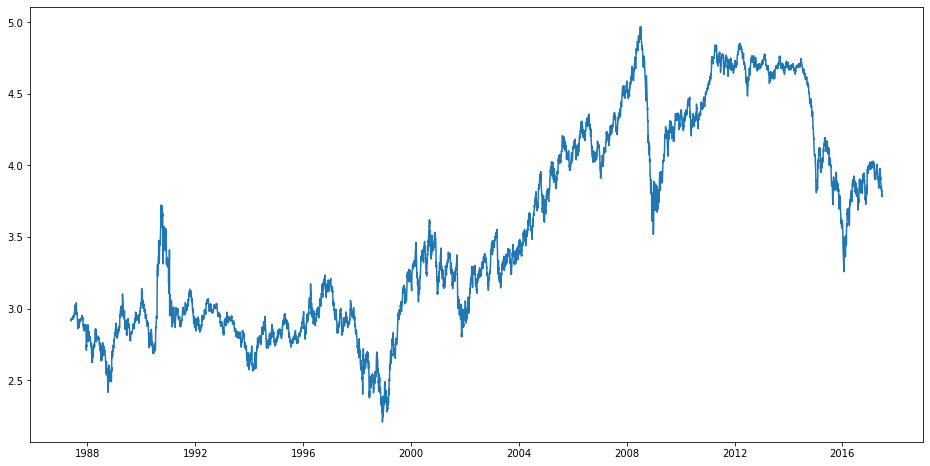

In [ ]:
Price_log = np.log(df['Price'])
plt.plot(Price_log)

In [ ]:
def adf(time_series):
    result_adf = adfuller(time_series)
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']

    for value,label in zip(result_adf,labels):
        print(label+' : '+str(value) )
    
    if result_adf[1] <= 0.05:
        print("Since we have a strong evidence against the null hypothesis, we reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("Since we have a weak evidence against null hypothesis. The time series has a unit root and is non-stationary")



adf_test = adf(Price_log)

Augmented Dickey-Fuller Test:
ADF Test Statistic : -1.6218134328603766
p-value : 0.47177871278948186
#Lags Used : 15
Number of Observations Used : 7625
Since we have a weak evidence against null hypothesis. The time series has a unit root and is non-stationary


Step 2: **Differencing**

Augmented Dickey-Fuller Test:
ADF Test Statistic : -20.65097857830883
p-value : 0.0
#Lags Used : 14
Number of Observations Used : 7625
Since we have a strong evidence against the null hypothesis, we reject the null hypothesis. Data has no unit root and is stationary


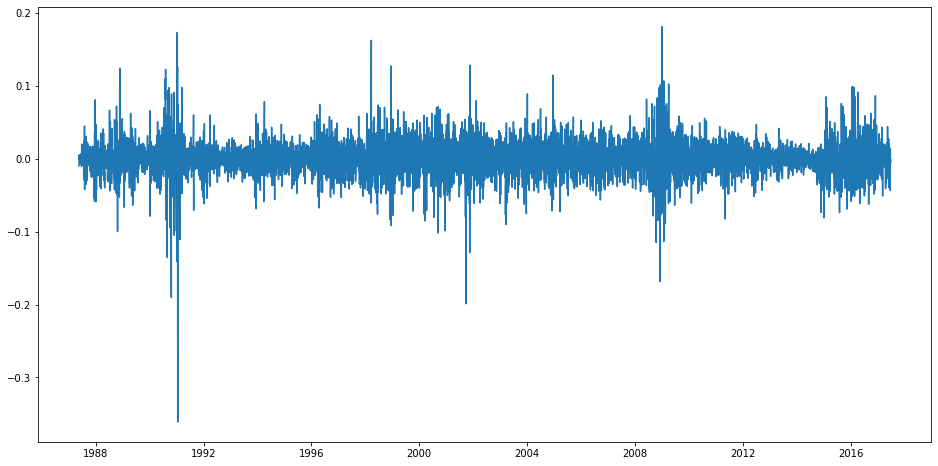

In [ ]:
Price_log_diff = Price_log - Price_log.shift()
Price_log_diff.dropna(inplace=True)
adf(Price_log_diff)
plt.plot(Price_log_diff)

Now the data is stationary.

Since differencing is applied only once to get a stationary time series, therefore d = 1.



---



# ARIMA Modeling

The forecasting model used in this analysis is known as the arima model. The model stands for AutoRegressive Integrated Moving Average.
The model has 3 hyperparameters -

- **p**: The AutoRegressive model's parameter. It defines the no. of past obsevations that help determine the current observation.

- **d**: The order of differencing. It defines the order to which differencing operation needs to be carried out in order to make the data stationary. In our data we have already converted the data to a stationary form, so ideally this parameter should be 1.

- **q**: The Moving Average model's parameter. This is used to define the no. of white noise terms(of previous observations) that help to describe the current observation.

Through rough intuition we have come across the idea that **d=1**. In order to guess the value of p and q we can plot **the partial auto correlation** and **the auto correlation** graphs respectively.

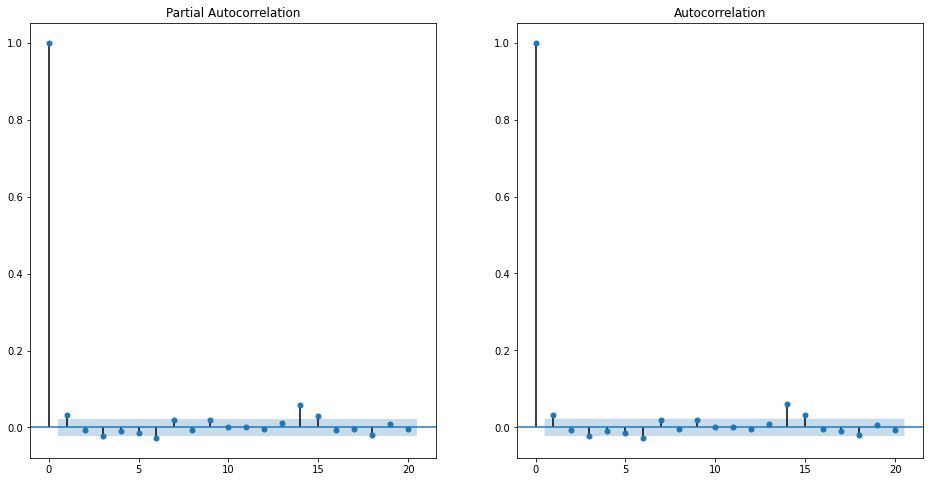

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)

# Plotting partial autocorrelation
p = plot_pacf(Price_log_diff, lags=20, ax=ax1)
# Plotting autocorrelation
q = plot_acf(Price_log_diff, lags=20, ax=ax2)



---



In [ ]:
# ! pip install --upgrade Cython
# ! pip install --upgrade git+https://github.com/statsmodels/statsmodels
# import statsmodels.api as sm

In [ ]:
# ! pip install --upgrade Cython
# ! pip install --upgrade git+https://github.com/statsmodels/statsmodels
# import pmdarima as pmd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/statsmodels/statsmodels to /tmp/pip-req-build-xtdznqql
  Running command git clone -q https://github.com/statsmodels/statsmodels /tmp/pip-req-build-xtdznqql




---



###**Tuning p-d-q via loop**

In [ ]:
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 2, 0),
 (0, 2, 1),
 (0, 2, 2),
 (1, 0, 0),
 (1, 0, 1),
 (1, 0, 2),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (1, 2, 0),
 (1, 2, 1),
 (1, 2, 2),
 (2, 0, 0),
 (2, 0, 1),
 (2, 0, 2),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2),
 (2, 2, 0),
 (2, 2, 1),
 (2, 2, 2)]

In [ ]:
warnings.filterwarnings('ignore')
def tune(series):
  d = 5
  param_df = pd.DataFrame(columns=['Parameter', 'AIC'])

  i=0
  for param in pdq:
      try:
          model_arima = ARIMA(series, order=param)
          model_arima_fit = model_arima.fit()
          param_df.loc[i] = [param, model_arima_fit.aic]
          i = i + 1
      except:
          continue
  print(d)
  print(param_df)
  #optimal parameters
  print(param_df[param_df['AIC']==param_df['AIC'].min()])

In [ ]:
tune(df['Price'])

5
    Parameter           AIC
0   (0, 0, 0)  75297.354311
1   (0, 0, 1)  65059.591620
2   (0, 1, 0)  22604.869111
3   (0, 1, 1)  22598.010456
4   (0, 1, 2)  22599.940936
5   (0, 2, 0)  27634.330960
6   (0, 2, 1)  22613.597565
7   (0, 2, 2)  22606.696394
8   (1, 0, 0)  22614.065933
9   (1, 0, 1)  22607.075236
10  (1, 0, 2)  22609.017797
11  (1, 1, 0)  22598.081200
12  (1, 1, 1)  22599.968950
13  (1, 1, 2)  22601.752273
14  (1, 2, 0)  25631.413468
15  (1, 2, 1)  22606.764361
16  (1, 2, 2)  22614.016535
17  (2, 0, 0)  22607.142184
18  (2, 0, 1)  22609.040518
19  (2, 0, 2)  22610.886970
20  (2, 1, 0)  22599.893877
21  (2, 1, 1)  22601.678423
22  (2, 1, 2)  22573.615747
23  (2, 2, 0)  24805.057403
24  (2, 2, 1)  22608.598048
25  (2, 2, 2)  22610.967365
    Parameter           AIC
22  (2, 1, 2)  22573.615747


In [ ]:
tune(Price_log)

5
    Parameter           AIC
0   (0, 0, 0)  16534.268599
1   (0, 0, 1)   6293.790945
2   (0, 1, 0) -36017.980225
3   (0, 1, 1) -36023.887875
4   (0, 1, 2) -36022.038702
5   (0, 2, 0) -30965.735025
6   (0, 2, 1) -35983.859983
7   (0, 2, 2) -35990.110359
8   (1, 0, 0) -36016.222784
9   (1, 0, 1) -36022.267123
10  (1, 0, 2) -36020.397777
11  (1, 1, 0) -36023.799308
12  (1, 1, 1) -36021.952726
13  (1, 1, 2) -36023.478776
14  (1, 2, 0) -32968.677862
15  (1, 2, 1) -35998.331712
16  (1, 2, 2) -36000.468580
17  (2, 0, 0) -36022.181764
18  (2, 0, 1) -36020.323969
19  (2, 0, 2) -36018.325486
20  (2, 1, 0) -36022.153611
21  (2, 1, 1) -36023.956915
22  (2, 1, 2) -36019.689135
23  (2, 2, 0) -33762.954100
24  (2, 2, 1) -36003.288164
25  (2, 2, 2) -35998.300293
    Parameter           AIC
21  (2, 1, 1) -36023.956915


In [ ]:
tune(Price_log_diff)

5
    Parameter           AIC
0   (0, 0, 0) -36017.980225
1   (0, 0, 1) -36023.887875
2   (0, 0, 2) -36022.038702
3   (0, 1, 0) -30965.735025
4   (0, 1, 1) -35983.859983
5   (0, 1, 2) -35990.110359
6   (0, 2, 0) -22669.608909
7   (0, 2, 1) -30925.099777
8   (0, 2, 2) -35307.949813
9   (1, 0, 0) -36023.799308
10  (1, 0, 1) -36021.952726
11  (1, 0, 2) -36023.478776
12  (1, 1, 0) -32968.677862
13  (1, 1, 1) -35998.331712
14  (1, 1, 2) -36000.468580
15  (1, 2, 0) -27009.314802
16  (2, 0, 0) -36022.153611
17  (2, 0, 1) -36023.956915
18  (2, 0, 2) -36019.689135
19  (2, 1, 0) -33762.954100
20  (2, 1, 1) -36003.288164
21  (2, 1, 2) -35998.300293
22  (2, 2, 0) -29043.889864
    Parameter           AIC
17  (2, 0, 1) -36023.956915





---


---


---



###**Tuning p-d-q via auto_arima**

In [ ]:

def arimamodel(timeseriesarray):
    autoarima_model = pmd.auto_arima(timeseriesarray, 
                              start_p=1, 
                              start_q=1,
                              test="adf",
                              trace=True)
    return autoarima_model

In [ ]:
arima_model2 = arimamodel(df['Price'])
arima_model2.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=22599.971, Time=2.37 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=22604.869, Time=0.31 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=22598.081, Time=1.39 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=22598.010, Time=1.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=22602.944, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=22599.941, Time=1.33 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=22601.792, Time=1.61 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=22596.081, Time=0.49 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=22598.041, Time=0.73 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=22598.012, Time=0.64 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=22596.151, Time=0.25 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=22599.864, Time=0.73 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 11.181 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 7641
Model:               SARIMAX(0, 1, 1)   Log Likelihood              -11296.040
Date:                Tue, 27 Dec 2022   AIC                          22596.081
Time:                        18:20:41   BIC                          22609.963
Sample:                             0   HQIC                         22600.843
                               - 7641                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0342      0.007      4.652      0.000       0.020       0.049
sigma2         1.1266      0.008    145.372      0.000       1.111       1.142
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             26610.72
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               9.92   Skew:                            -0.22
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
arima_model3 = arimamodel(Price_log)
arima_model3.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-36021.940, Time=5.41 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-36017.980, Time=1.65 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-36023.799, Time=0.49 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-36023.887, Time=2.23 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-36019.795, Time=0.36 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-36022.027, Time=2.41 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-36021.980, Time=3.89 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-36025.713, Time=0.86 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-36023.765, Time=1.37 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-36023.852, Time=1.40 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-36025.626, Time=0.24 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-36023.796, Time=1.60 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 22.076 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 7641
Model:               SARIMAX(0, 1, 1)   Log Likelihood               18014.857
Date:                Tue, 27 Dec 2022   AIC                         -36025.713
Time:                        18:22:06   BIC                         -36011.831
Sample:                             0   HQIC                        -36020.950
                               - 7641                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0321      0.007      4.538      0.000       0.018       0.046
sigma2         0.0005   3.04e-06    172.598      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             60617.96
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.99   Skew:                            -0.53
Prob(H) (two-sided):                  0.81   Kurtosis:                        16.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
arima_model = arimamodel(Price_log_diff)
arima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-36021.940, Time=14.31 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-36017.980, Time=2.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-36023.799, Time=0.93 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-36023.887, Time=4.49 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-36019.795, Time=0.68 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-36022.027, Time=6.53 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-36021.980, Time=6.94 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-36025.713, Time=0.79 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-36023.765, Time=1.02 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-36023.852, Time=1.17 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-36025.626, Time=0.22 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-36023.796, Time=1.69 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 40.897 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 7640
Model:               SARIMAX(0, 0, 1)   Log Likelihood               18014.857
Date:                Tue, 27 Dec 2022   AIC                         -36025.713
Time:                        18:01:31   BIC                         -36011.831
Sample:                             0   HQIC                        -36020.950
                               - 7640                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0321      0.007      4.538      0.000       0.018       0.046
sigma2         0.0005   3.04e-06    172.598      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             60617.96
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.99   Skew:                            -0.53
Prob(H) (two-sided):                  0.81   Kurtosis:                        16.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**AIC** stands for **Akaike Information Criterion**, which estimates the relative amount of information lost by a given model. In simple terms, a lower AIC value is preferred. In the above output, the lowest AIC value of -36025.713 was obtained for the ARIMA(0, 0, 0) model, and that is used as the final estimator.



---



###**Building and fitting**

**Results of optimal parameters are as follows:**

tune(df['Price'])      (2, 1, 2)  22573.615747

tune(Price_log)        (2, 1, 1) -36023.956915

tune(Price_log_diff)   (2, 0, 1) -36023.956915

--- ------ ----- ---- ---- ---- ---- ---- ---- ---- -----

auto_arima df['Price']     Model:	SARIMAX(0, 1, 1)	AIC	22596.081

auto_arima Price_log       Model:	SARIMAX(0, 1, 1)	AIC	-36025.713

auto_arima Price_log_diff  Model:	SARIMAX(0, 0, 1)	AIC	-36025.713
--- ------ ----- ---- ---- ---- ---- ---- ---- ---- -----

Both parameter tuning was showed similar results, our eyes are on 

the tune(Price_log)        (2, 1, 1) -36023.956915

since we need to pass the log transformed values to the ARIMA class in order to create the instance of the model.

In [ ]:
# Create Training and Test Data
train = Price_log[:7300]
test = Price_log[7300:]

print('Price_log size : ', Price_log.size)
print('train size : ', train.size)
print('test size : ', test.size)

Price_log size :  7641
train size :  7300
test size :  341


In [ ]:
tune(train)

5
    Parameter           AIC
0   (0, 0, 0)  16052.445448
1   (0, 0, 1)   6255.155759
2   (0, 1, 0) -34404.757336
3   (0, 1, 1) -34411.619886
4   (0, 1, 2) -34409.927910
5   (0, 2, 0) -29604.206864
6   (0, 2, 1) -34373.128404
7   (0, 2, 2) -34380.152574
8   (1, 0, 0) -34403.017805
9   (1, 0, 1) -34410.009091
10  (1, 0, 2) -34408.291063
11  (1, 1, 0) -34411.481326
12  (1, 1, 1) -34409.755133
13  (1, 1, 2) -34411.742361
14  (1, 2, 0) -31494.874685
15  (1, 2, 1) -34387.746112
16  (1, 2, 2) -34389.379170
17  (2, 0, 0) -34409.873312
18  (2, 0, 1) -34408.134378
19  (2, 0, 2) -34409.924756
20  (2, 1, 0) -34410.099518
21  (2, 1, 1) -34412.261979
22  (2, 1, 2) -34409.729898
23  (2, 2, 0) -32251.471029
24  (2, 2, 1) -34391.479351
25  (2, 2, 2) -34387.413778
    Parameter           AIC
21  (2, 1, 1) -34412.261979


In [ ]:
model =ARIMA(train, order=(2,1,1))
model_fit = model.fit()
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Price   No. Observations:                 7299
Model:                 ARIMA(2, 1, 1)   Log Likelihood               17211.131
Method:                       css-mle   S.D. of innovations              0.023
Date:                Wed, 28 Dec 2022   AIC                         -34412.262
Time:                        16:22:46   BIC                         -34377.785
Sample:                             1   HQIC                        -34400.407
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          8.882e-05      0.000      0.340      0.734      -0.000       0.001
ar.L1.D.Price     0.7241      0.124      5.863      0.000       0.482       0.966
ar.L2.D.Price    -0.0424      0.012     

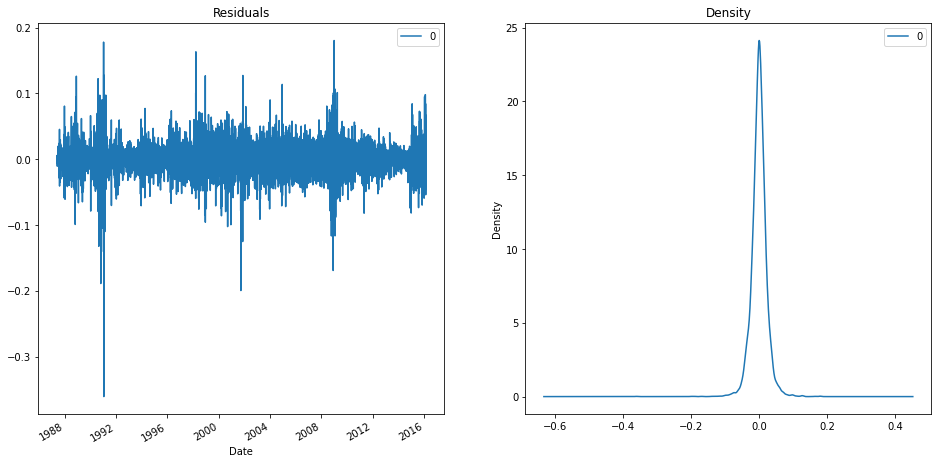

In [ ]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [ ]:
Price_log.index[-1]

Timestamp('2017-06-26 00:00:00')

In [ ]:
from pandas import Timestamp

In [ ]:
#ARIMA model in-sample and out-of-sample prediction

# arima_pred = model_fit.predict(Price_log.index[-2000], Price_log.index[-1], typ="levels")

# plt.plot(Price_log, label='Original')
# plt.plot(arima_pred, label='Prediction')
# plt.legend(loc=2)
# plt.title('RMSE: %.4f'% np.sqrt(sum((arima_pred-Price_log[253:])**2)/len(Price_log[253:])))

### **Forecasting and evaluating**

The fitted model is used to forecast the future values(341 values) that span over the testing set. The lower and upper variables store the lower and upper confidence levels for the predictions. The confidence level is set to alpha=0.90.

In [ ]:
# Out-of-sample forecasts
model_predictions = model_fit.forecast(341, alpha=0.90) #test.size = 341

In [ ]:
predict = model_predictions[0]
lower = model_predictions[2][:, 0]
upper = model_predictions[2][:, 1]

In [ ]:
# Make as pandas series
predict_ser = pd.Series(predict, index=test.index)
lower_ser = pd.Series(lower, index=test.index)
upper_ser = pd.Series(upper, index=test.index)

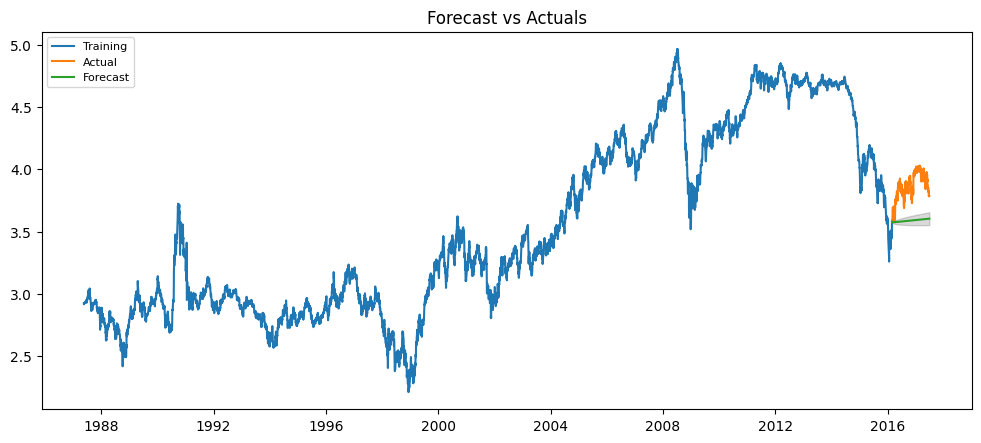

In [ ]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='Training')
plt.plot(test, label='Actual')
plt.plot(predict_ser, label='Forecast')
plt.fill_between(lower_ser.index, lower_ser, upper_ser, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
# Accuracy metrics
def accuracy_metrics(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(predict-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

accuracy_metrics(predict, test.values)

{'mape': 0.07109850702810044,
 'me': -0.27745536489086653,
 'mae': 0.2774655692897761,
 'mpe': -0.07109565344154349,
 'rmse': 0.2951183219469014,
 'acf1': 0.9621456853324155,
 'corr': 0.6465494208030632,
 'minmax': 0.07109850633425108}



---

